In [5]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #

import xtrack as xt
import xobjects as xo
import xpart as xp

import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm


beta_rel=0.09423258405
gamma = 1.004469679

current=0.6 #ampere
cooler_length = 3 # m cooler length
r_beam=25*1e-3



T_perp = 0.01 # <E> [eV] = kb*T
T_l =  0.001 # <E> [eV]
magnetic_field = 0.07 # T for LEIR
B_ratio=0
Neutralisation_space_charge=1

c=299792458.0

mass0=193729.0248722061*1e6 #eV/c2
c=299792458.0
p0c = mass0*beta_rel*gamma #eV/c
q0=54


circumference = 78.54370266 #m
T = circumference/(c*beta_rel)
ms_per_turn = 1000*T
s_per_turn = T

print('T:',1/T)

beta_x=5
beta_y=5


disp_x=0
Q_x=1.82
Q_y=2.72
dQx=-0.0005113579791
dQy=-0.0001665178543

arc = xt.LineSegmentMap(
        qx=Q_x, qy=Q_y, qs=0,
        dqx=dQx, dqy=dQy,
        bets = 1*1e40, length=circumference,
        betx=beta_x,
        bety=beta_y
        )


T: 359675.1494939148


In [6]:
num_particles=10000
# Define the save interval
save_interval = 100

#old
emittance=14*1e-6 #inital emittance

sigma_x = np.sqrt(beta_x*emittance)
sigma_px = np.sqrt(emittance*1/beta_x)
sigma_y = np.sqrt(beta_y*emittance)
sigma_py = np.sqrt(emittance*1/beta_y)
sigma_p = 5e-3

delta = np.random.normal(loc=0.0, scale=sigma_p, size=num_particles)
x = np.random.normal(loc=0.0, scale=sigma_x, size=num_particles) + disp_x * delta
px = np.random.normal(loc=0.0, scale=sigma_px, size=num_particles)
y = np.random.normal(loc=0.0, scale=sigma_y, size=num_particles)
py = np.random.normal(loc=0.0, scale=sigma_py, size=num_particles)

particles = xp.Particles(
    mass0=mass0,
    p0c=p0c,
    q0=q0,
    x=x,
    px=px,
    y=y,
    py=py,
    delta=delta,
    zeta=0
)

cooler = xt.ElectronCooler(current=current, length=cooler_length, r_beam=r_beam,
                           T_perp=T_perp, T_l=T_l,
                           magnetic_field=magnetic_field, B_ratio=B_ratio,
                           Neutralisation_space_charge=Neutralisation_space_charge)

num_turns = int(4 * 1e5)
num_turns = 359675  # 1sec

x_list = []
px_list = []
y_list = []
py_list = []
action_x_list = []
emittance_list = []

# Perform the loop
for i in tqdm(range(num_turns)):
    if i % save_interval == 0:
        x_xs = particles.x.copy()
        px_xs = particles.px.copy()
        y_xs = particles.y.copy()
        py_xs = particles.py.copy()

        action_x_temp = (x_xs ** 2 / beta_x + beta_x * px_xs ** 2)

        cov00 = np.cov(x_xs, px_xs)
        det00 = np.sqrt(np.linalg.det(cov00))

        x_list.append(x_xs)
        px_list.append(px_xs)
        y_list.append(y_xs)
        py_list.append(py_xs)
        action_x_list.append(action_x_temp)
        emittance_list.append(det00)

    arc.track(particles)
    cooler.track(particles)

time = np.arange(0, num_turns, save_interval) * s_per_turn
print('Done')

100%|██████████| 359675/359675 [19:33<00:00, 306.43it/s]

Done


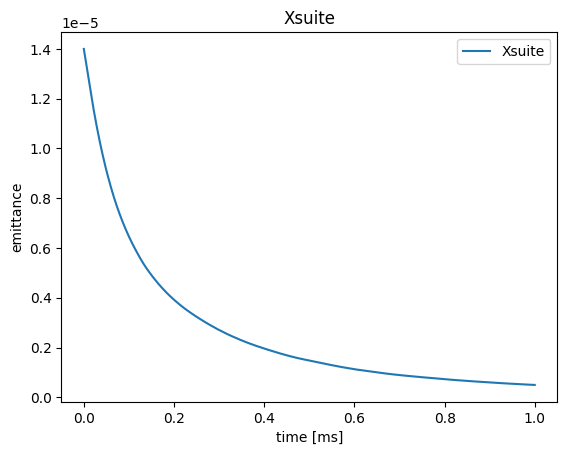

In [7]:
plt.figure()
plt.title('Xsuite')
#plt.plot(emittance_rf_list,label='RF Track')
plt.plot(time,emittance_list,label='Xsuite')
plt.xlabel('time [ms]')
plt.ylabel('emittance')
plt.legend()
plt.show()

In [8]:

filepath=f'results/emittance_xsuite_sc={Neutralisation_space_charge}.npz'


np.savez(filepath, time=time, emittance=emittance_list)